<a href="https://colab.research.google.com/github/czhurdlespeed/TFDevCert/blob/main/TFCert_Practice/06_transfer_learning_tensorflow_scalingup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up (Food vision mini)

> Goal is to beat the original Food101 paper (>50.76% accuracy across 101 classes) with 10% of the data leveraging transfer learning

In [1]:
# Check GPU
!nvidia-smi

Sun Jan 21 00:36:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

Let's download previous helper functions from earlier notebooks



In [2]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py

--2024-01-21 00:36:50--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2024-01-21 00:36:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-21 00:36:51 (85.2 MB/s) - ‘helper_

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
# Data we are download has already been preprocessed using the image_data_modification notebook
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-21 00:36:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.4MB/s    in 74s     

2024-01-21 00:38:11 (20.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning with 10% of 101 food classes

Here are the steps:
1. Create a model checkpoint callback
2. Create a data augmentation layer to build data aug right into the model
3. Build a headless Functional EfficientNetB0 backboned-model
4. Compile our model
5. Feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of test data)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,)

In [8]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


# Setup data aug
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

In [9]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # only happens during training phase
x = base_model(x, training=False) # weights stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 2s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [12]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs = 5,
                                            validation_data = test_data,
                                            validation_steps = int(.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 160s 629ms/step - loss: 3.3683 - accuracy: 0.2709 - val_loss: 2.3617 - val_accuracy: 0.5260
Epoch 2/5
237/237 [==============================] - 107s 448ms/step - loss: 2.2007 - accuracy: 0.4949 - val_loss: 1.9750 - val_accuracy: 0.5434
Epoch 3/5
237/237 [==============================] - 93s 389ms/step - loss: 1.8211 - accuracy: 0.5633 - val_loss: 1.7966 - val_accuracy: 0.5577
Epoch 4/5
237/237 [==============================] - 83s 346ms/step - loss: 1.6049 - accuracy: 0.6078 - val_loss: 1.7449 - val_accuracy: 0.5606
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.4542 - accuracy: 0.6333 - val_loss: 1.7078 - val_accuracy: 0.5564


In [13]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.5941 - accuracy: 0.5782


[1.5941307544708252, 0.5782178044319153]

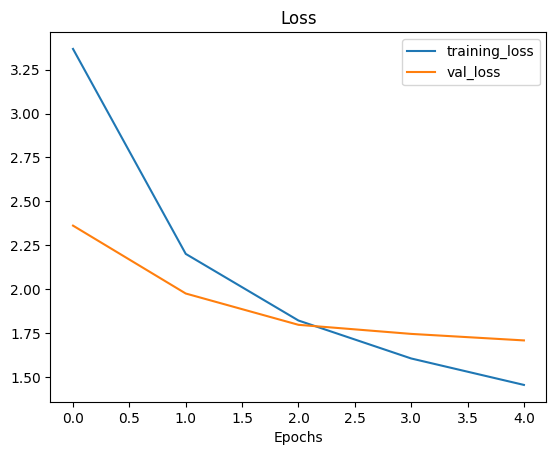

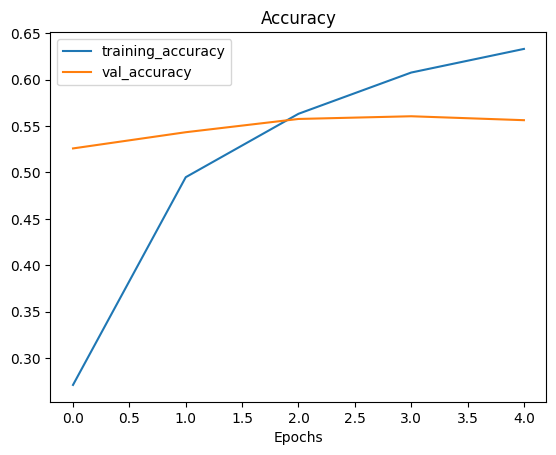

In [14]:
plot_loss_curves(history_all_classes_10_percent)

> Looks like some overfitting is occuring; model bias

## Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False



In [16]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

In [17]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [19]:
# Check trainable layers in base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
fine_tune_epochs = 10
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs = fine_tune_epochs,
          validation_data = test_data,
          validation_steps = int(0.15*len(test_data)),
          initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 85s 320ms/step - loss: 1.2075 - accuracy: 0.6863 - val_loss: 1.6658 - val_accuracy: 0.5633
Epoch 6/10
237/237 [==============================] - 67s 280ms/step - loss: 1.0934 - accuracy: 0.7139 - val_loss: 1.6725 - val_accuracy: 0.5649
Epoch 7/10
237/237 [==============================] - 65s 271ms/step - loss: 1.0103 - accuracy: 0.7312 - val_loss: 1.6769 - val_accuracy: 0.5638
Epoch 8/10
237/237 [==============================] - 59s 248ms/step - loss: 0.9406 - accuracy: 0.7460 - val_loss: 1.6688 - val_accuracy: 0.5678
Epoch 9/10
237/237 [==============================] - 59s 246ms/step - loss: 0.8904 - accuracy: 0.7603 - val_loss: 1.7011 - val_accuracy: 0.5591
Epoch 10/10
237/237 [==============================] - 57s 238ms/step - loss: 0.8272 - accuracy: 0.7799 - val_loss: 1.6794 - val_accuracy: 0.5625


In [22]:
# Evaluate on the whole dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.4831 - accuracy: 0.6065


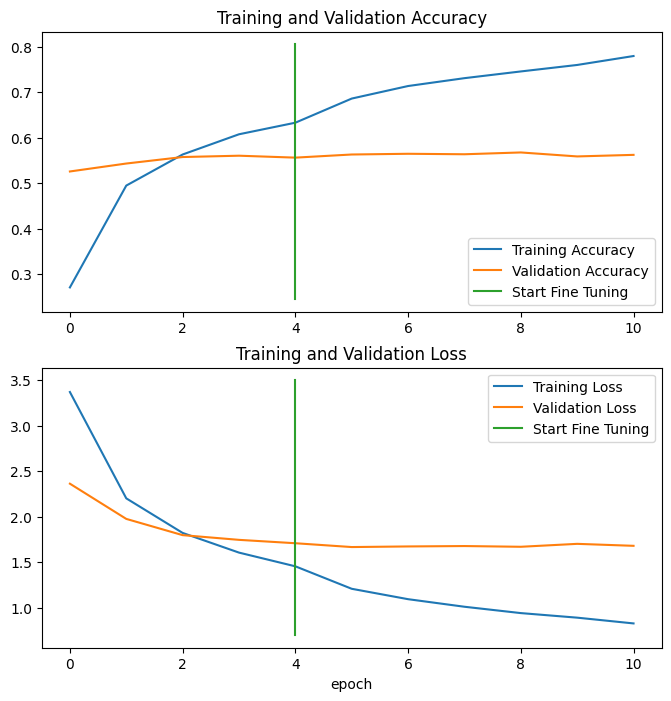

In [23]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune, 5)

## Saving and loading our model

In [34]:
model.save("drive/MyDrive/101_food_classes_10_percent_saved_model.keras")

In [36]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/101_food_classes_10_percent_saved_model.keras")

In [38]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [39]:
loaded_model_results = loaded_model.evaluate(test_data)


790/790 [==============================] - 68s 83ms/step - loss: 1.4831 - accuracy: 0.6065


In [40]:
import numpy as np
print(np.isclose(loaded_model_results, all_classes_10_percent_fine_tune_results))

[ True  True]
